# Do the scoliosis EMG analysis for one patient

In [1]:
import pathlib

import numpy as np
from collections import defaultdict

import pandas as pd

from gaitutils.stats import collect_trial_data
from gaitutils.trial import Trial
from gaitutils import eclipse
from gaitutils.config import cfg

import matplotlib.pyplot as plt
#%matplotlib widget

In [2]:
#DATA_FLDR = 'Y:/Userdata_Vicon_Server/Skolioosi/Potilaina/E0145_AA/2022_02_10_Seur_AA'
#DATA_FLDR = 'Y:/Userdata_Vicon_Server/Skolioosi/Potilaina/E0173_GL/2023_02_16_skolioosi_seur_GL'
#DATA_FLDR = 'Y:/Userdata_Vicon_Server/Skolioosi/Potilaina/E0148_AK/2022_04_11_Seur_AK'
#DATA_FLDR = 'Y:/Userdata_Vicon_Server/Skolioosi/Potilaina/E0150_EA/2022_05_05_seur_EA'
#DATA_FLDR = 'Y:/Userdata_Vicon_Server/Skolioosi/Potilaina/E0156_EO/2022_8_8_PreKorsetti'
#DATA_FLDR = 'Y:/Userdata_Vicon_Server/Skolioosi/Potilaina/E0163_IR/2022_11_17_skolioosi_IR'
DATA_FLDR = '/home/andrey/scratch/scoliosis/E0145'
WALKING_TAGS = {'E1', 'E2', 'E3', 'E4', 'T1', 'T2', 'T3', 'T4'}
MVC_TAG = 'MVC'
VETO_TAG = 'vetokävely'

REMOVE_MARG = 2 # seconds, only applies to MVC and veto trials
CONV_KERN_LENGTH = 2 # seconds
cfg.trial.no_toeoff = 'reject'
cfg.emg.envelope_method = 'linear_envelope'
cfg.emg.linear_envelope_lowpass = 10

## Read all the walking files

In [3]:
emg_walk = defaultdict(lambda: np.zeros((1000,0)))

for c3d_file in pathlib.Path(DATA_FLDR).glob('*.c3d'):
    print(f'Reading file {c3d_file} ...')
    trial = Trial(c3d_file)
    
    if trial.eclipse_tag in WALKING_TAGS:
        print(f'Collecting trial data for file {c3d_file} (walking) ...')
        data, cycles = collect_trial_data(trial, analog_envelope=True, force_collect_all_cycles=True, fp_cycles_only=False)
        for ch in data['emg'].keys():
            emg_walk[ch] = np.hstack((emg_walk[ch], data['emg'][ch].T))

Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA13.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA06.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA14.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA17.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA18.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA08.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA02.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA25.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA27.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA22.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA33.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA15.c3d ...
Reading file /home/andrey/scratch/scoliosis/E0145/20

## Read all the reference files

In [4]:
emg_mvc = defaultdict(lambda: np.zeros((0,)))
emg_veto = defaultdict(lambda: np.zeros((0,)))
sfrate = None

for c3d_file in pathlib.Path(DATA_FLDR).glob('*.c3d'):
    trial = Trial(c3d_file)
    trial.get_emg_data(next(iter(emg_walk.keys())))

    if sfrate is None:
        sfrate = trial.emg.sfrate
    else:
        # All the trials should have the same sampling rate
        assert sfrate == trial.emg.sfrate


    if MVC_TAG in eclipse.get_eclipse_keys(trial.enfpath)['NOTES'] or MVC_TAG in eclipse.get_eclipse_keys(trial.enfpath)['DESCRIPTION']:
        print(f'Reading file {c3d_file} (MVC) ...')
        for ch in emg_walk.keys():
            ch_data = trial.get_emg_data(ch, envelope=True)[1]
            ch_data = ch_data[round(REMOVE_MARG*sfrate):-round(REMOVE_MARG*sfrate)]
            emg_mvc[ch] = np.concatenate((emg_mvc[ch], ch_data))

    if VETO_TAG in eclipse.get_eclipse_keys(trial.enfpath)['NOTES'] or VETO_TAG in eclipse.get_eclipse_keys(trial.enfpath)['DESCRIPTION']:
        print(f'Reading file {c3d_file} (veto) ...')
        for ch in emg_walk.keys():
            ch_data = trial.get_emg_data(ch, envelope=True)[1]
            ch_data = ch_data[round(REMOVE_MARG*sfrate):-round(REMOVE_MARG*sfrate)]
            emg_veto[ch] = np.concatenate((emg_veto[ch], ch_data))

Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA35.c3d (veto) ...
Reading file /home/andrey/scratch/scoliosis/E0145/2022_02_10_Seur_AA36.c3d (MVC) ...


## Find maxima

In [5]:
kernel = np.ones(round(CONV_KERN_LENGTH * sfrate))    # Note that we are using sampling rate from the last trial we read, assuming that all trials have the same sampling rate
kernel /= kernel.sum()

emg_mvc_max = {}
emg_veto_max = {}

for ch in emg_walk:
    emg_mvc_max[ch] = np.convolve(emg_mvc[ch], kernel, mode='valid').max()
    emg_veto_max[ch] = np.convolve(emg_veto[ch], kernel, mode='valid').max()

## Normalize

In [6]:
for ch in emg_walk:
    emg_walk[ch] /= emg_mvc_max[ch]

## Plot

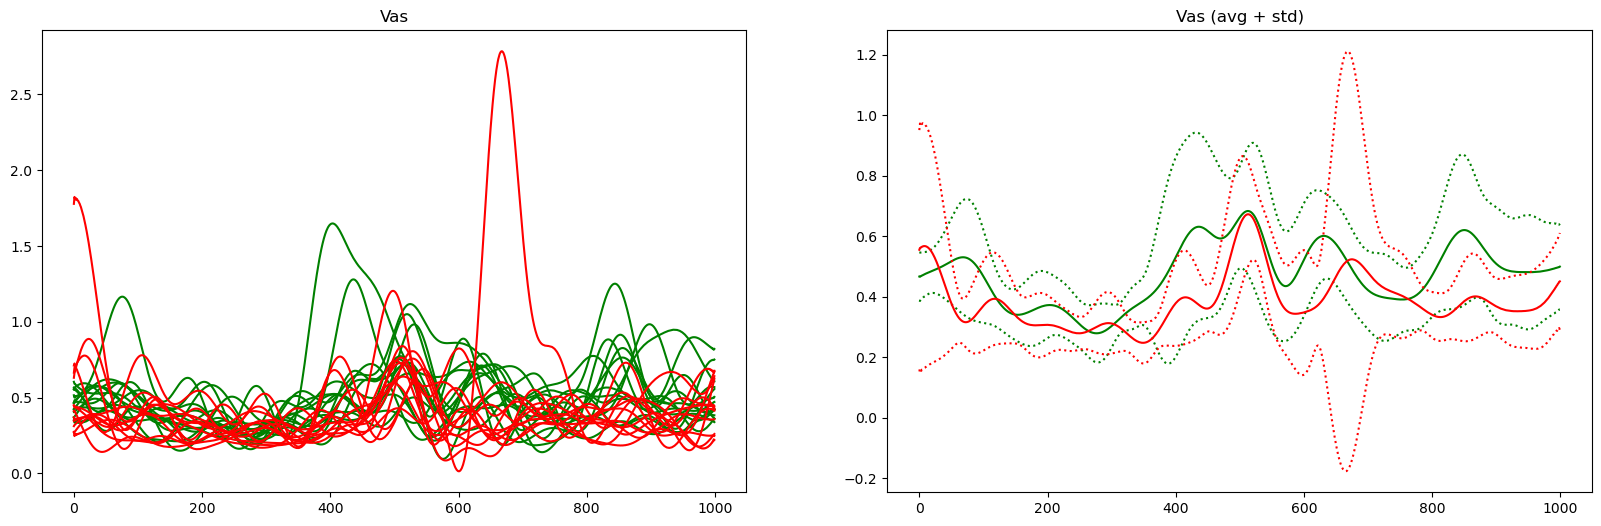

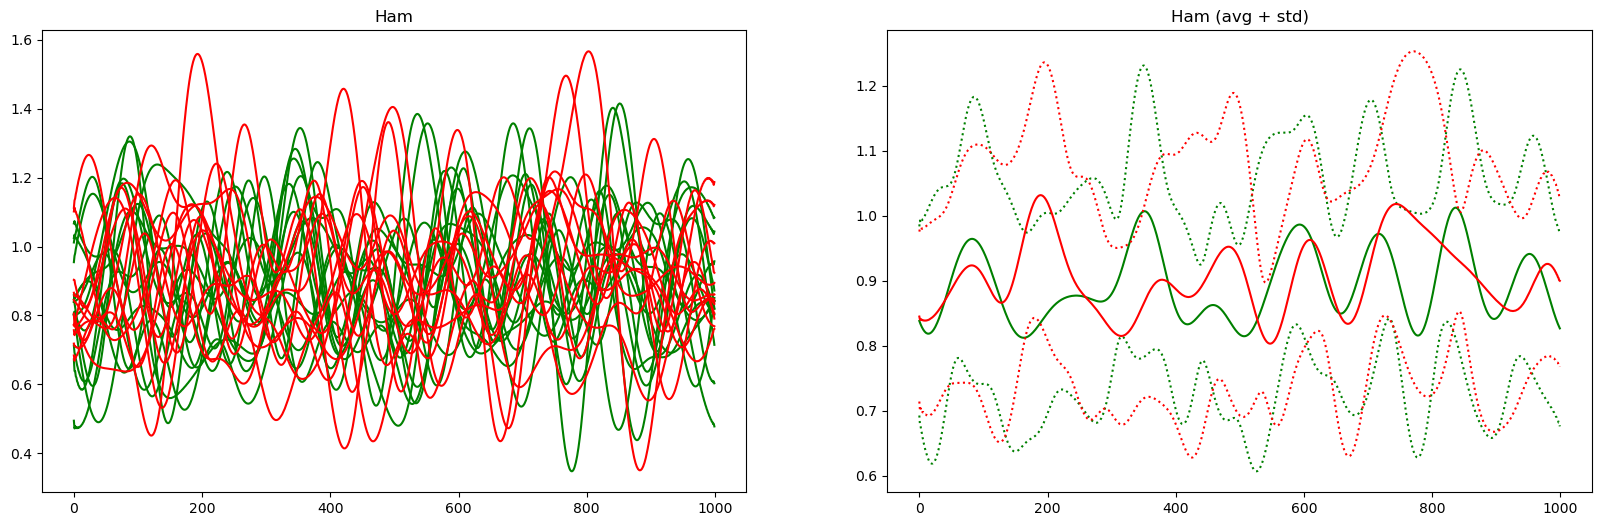

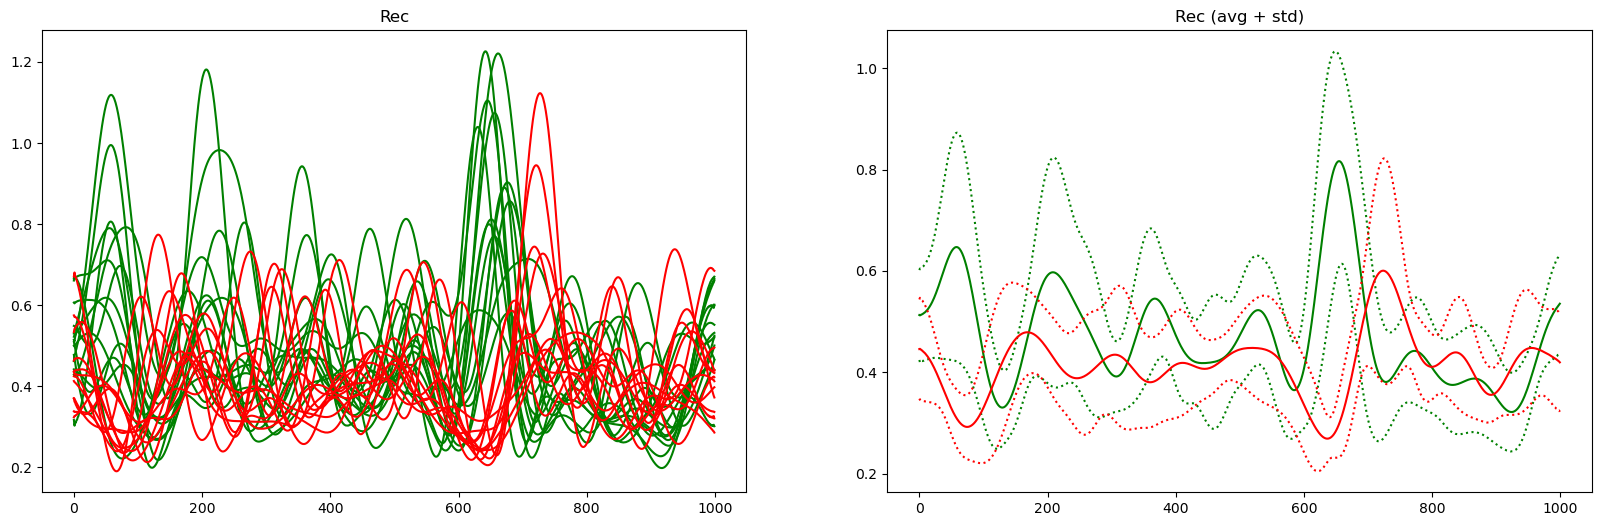

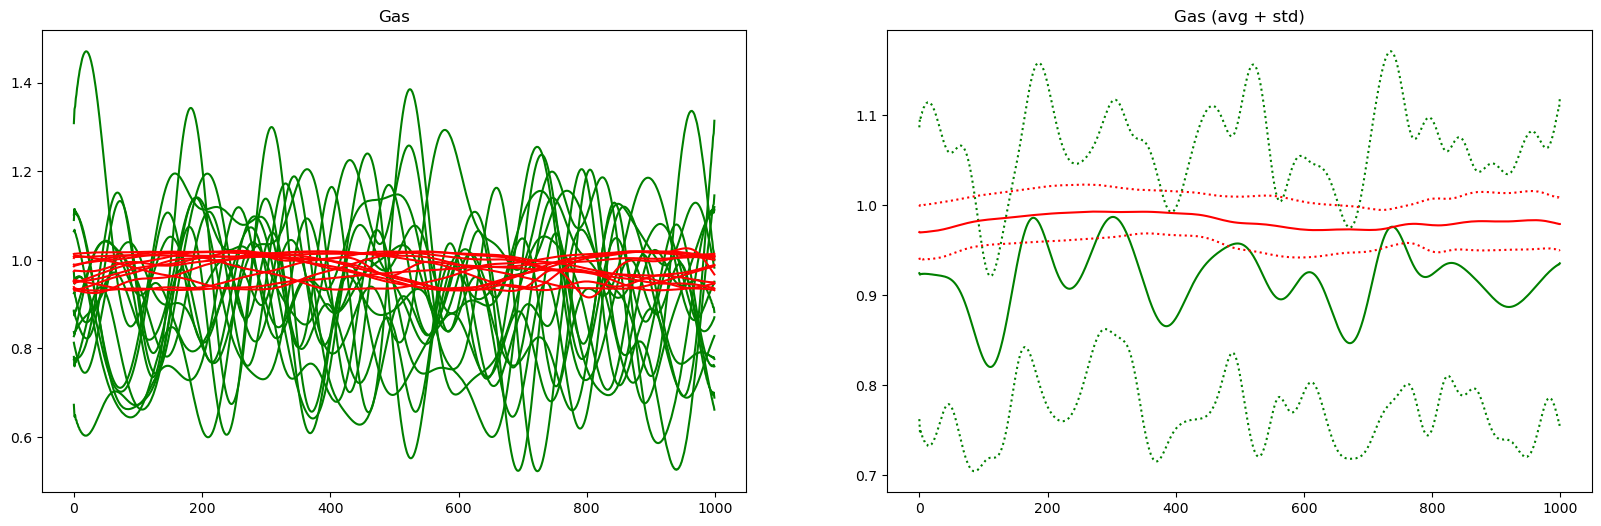

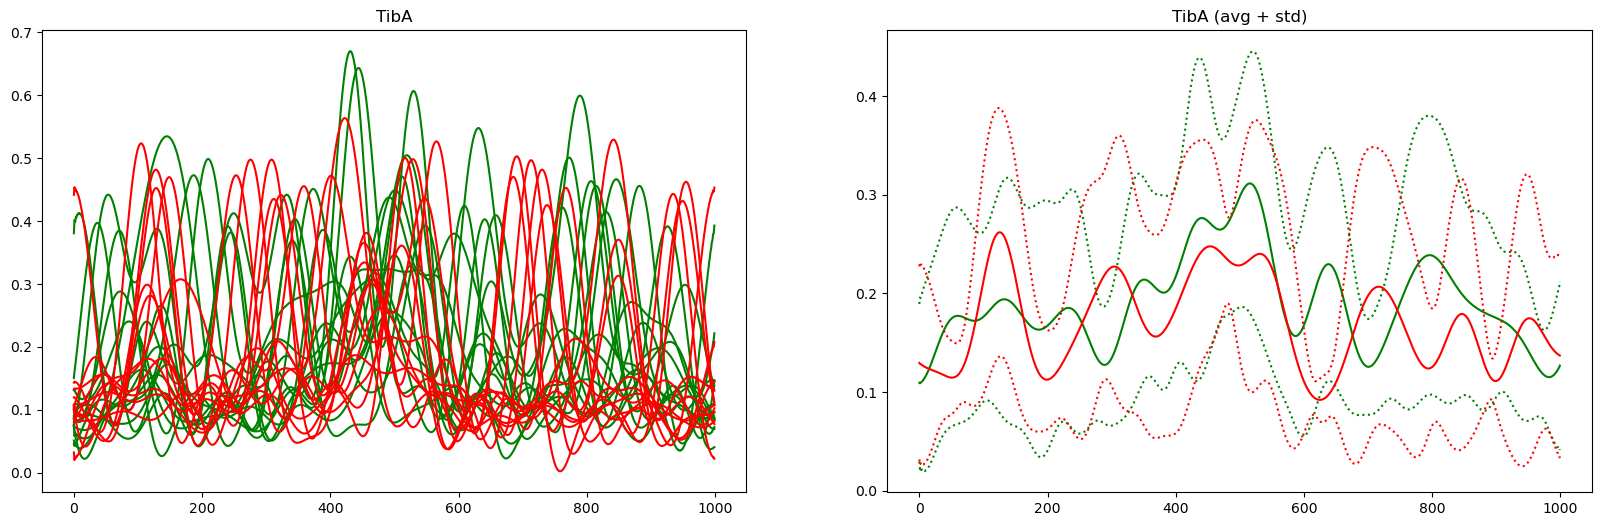

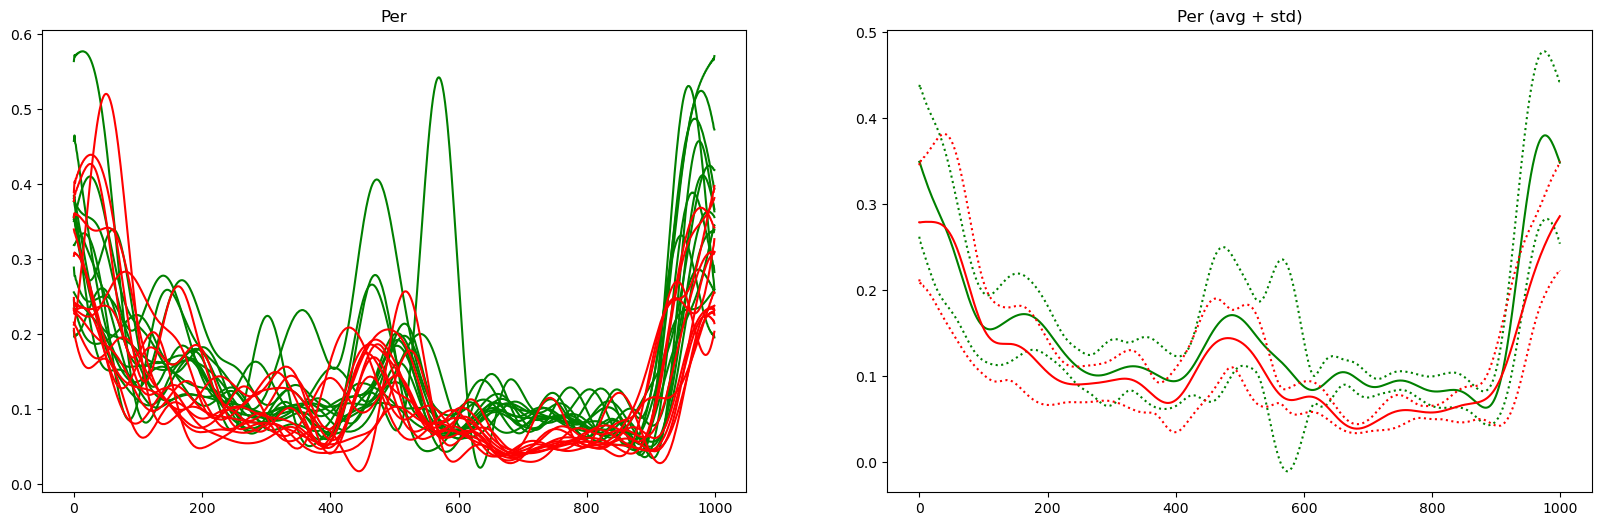

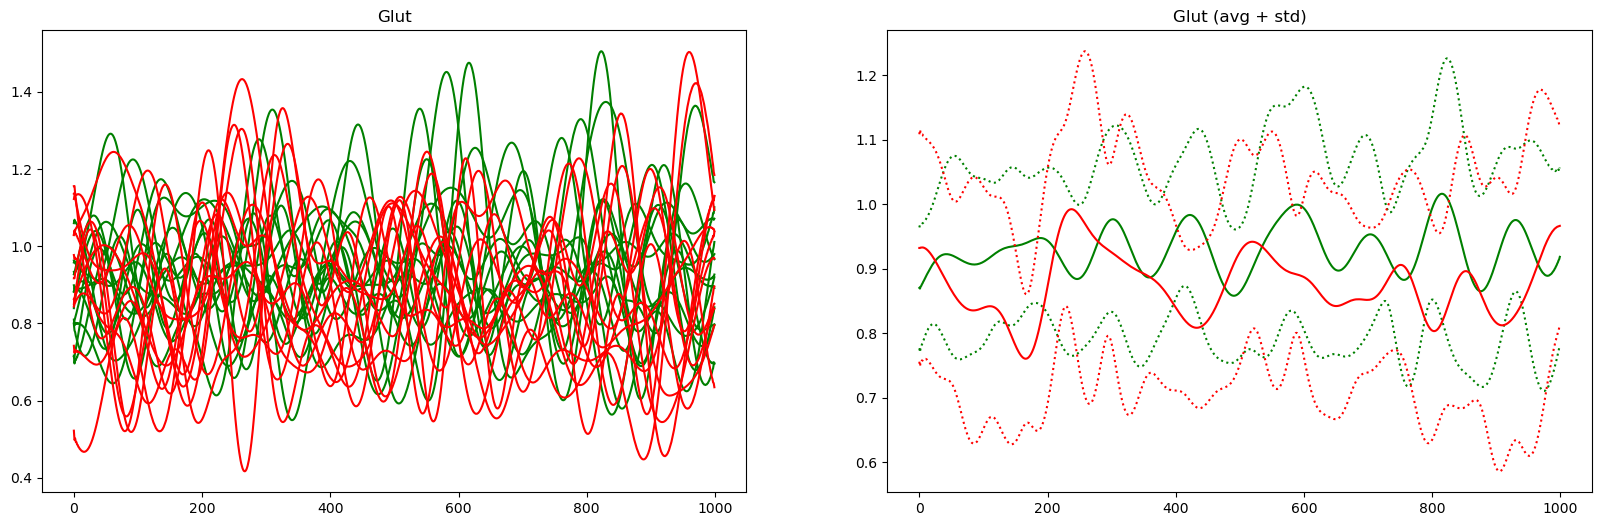

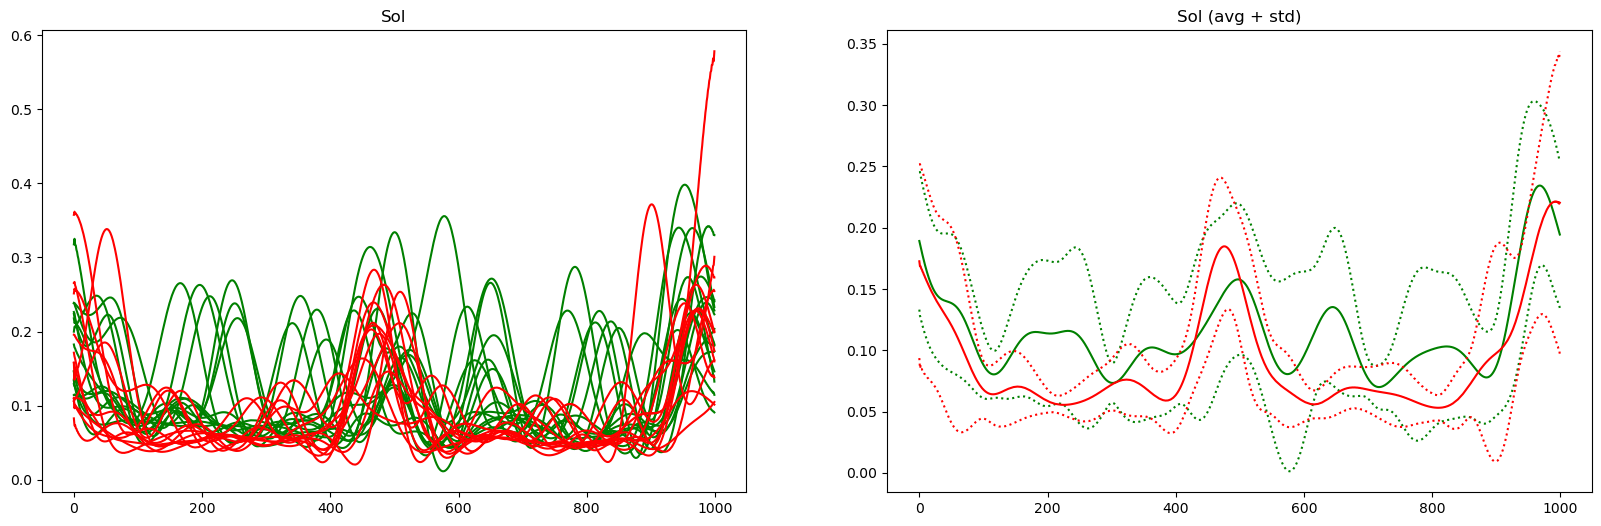

In [7]:
ch_base = set(ch[1:] for ch in emg_walk.keys())

for ch in ch_base:
    plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.plot(emg_walk[f'R{ch}'], color='green')
    plt.plot(emg_walk[f'L{ch}'], color='red')
    plt.title(f'{ch}')
    
    plt.subplot(1, 2, 2)
    plt.plot(emg_walk[f'R{ch}'].mean(axis=1), color='green')
    plt.plot(emg_walk[f'R{ch}'].mean(axis=1) + emg_walk[f'R{ch}'].std(axis=1), color='green', linestyle='dotted')
    plt.plot(emg_walk[f'R{ch}'].mean(axis=1) - emg_walk[f'R{ch}'].std(axis=1), color='green', linestyle='dotted')

    plt.plot(emg_walk[f'L{ch}'].mean(axis=1), color='red')
    plt.plot(emg_walk[f'L{ch}'].mean(axis=1) + emg_walk[f'L{ch}'].std(axis=1), color='red', linestyle='dotted')
    plt.plot(emg_walk[f'L{ch}'].mean(axis=1) - emg_walk[f'L{ch}'].std(axis=1), color='red', linestyle='dotted')

    plt.title(f'{ch} (avg + std)')
    plt.gcf().set_size_inches(20, 6)


## Compute the indices

In [8]:
res = {'index': ('right max', 'std of (right max)', 'left max', 'std of (left max)', 'right average', 'left average', 'right mvc', 'left mvc', 'right veto', 'left veto')}
                 
for ch in ch_base:
    res[ch] = (np.mean(emg_walk[f'R{ch}'].max(axis=0)),
               np.std(emg_walk[f'R{ch}'].max(axis=0)),
               np.mean(emg_walk[f'L{ch}'].max(axis=0)),
               np.std(emg_walk[f'L{ch}'].max(axis=0)),
               emg_walk[f'R{ch}'].mean(),
               emg_walk[f'L{ch}'].mean(),
               emg_mvc_max[f'R{ch}'],
               emg_mvc_max[f'L{ch}'],
               emg_veto_max[f'R{ch}'],
               emg_veto_max[f'L{ch}'])
    
df = pd.DataFrame(res)
df

,index,Vas,Ham,Rec,Gas,TibA,Per,Glut,Sol
0,right max,0.969907,1.281247,0.984748,1.263964,0.503687,0.448163,1.307372,0.297289
1,std of (right max),0.246171,0.085525,0.154317,0.088474,0.084784,0.092171,0.109603,0.047489
2,left max,1.036990,1.359121,0.749837,1.018008,0.496946,0.363324,1.304788,0.299371
3,std of (left max),0.620260,0.135949,0.141055,0.004499,0.028853,0.073790,0.088767,0.097355
4,right average,0.474086,0.893682,0.473497,0.917041,0.191173,0.143531,0.929081,0.114008
5,left average,0.385464,0.904999,0.413300,0.982038,0.170853,0.114470,0.874388,0.089787
6,right mvc,0.000065,0.000200,0.000026,0.000110,0.000138,0.000146,0.000100,0.000160
7,left mvc,0.000071,0.000166,0.000031,0.002454,0.000139,0.000223,0.000112,0.000218
8,right veto,0.000059,0.000198,0.000013,0.000106,0.000068,0.000057,0.000097,0.000060
9,left veto,0.000024,0.000168,0.000016,0.002477,0.000062,0.000069,0.000109,0.000079


## Scratch area